In [36]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [37]:
import numpy as np

def fill_missing_value(row, df):
    # Obtener las columnas de características (excepto 'anyo' y 'valor')
    features = row.drop(['anyo', 'valor'])

    # Filtrar el DataFrame para buscar coincidencias
    matches = df.loc[(df.drop(['anyo', 'valor'], axis=1) == features).all(axis=1)]

    if len(matches) == 0 or pd.isnull(row['valor']):
        return 0

    # Calcular la media de los valores encontrados en las coincidencias
    fill_value = matches['valor'].mean()

    return int(np.round(fill_value))




In [38]:
def open_csv(df_name):
    """
    Opens a CSV file and performs data cleaning and transformation.

    Args:
        df_name (str): The name of the CSV file to open.

    Returns:
        pd.DataFrame: The cleaned and transformed DataFrame.

    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(df_name, sep=',', keep_default_na=False, na_values=[""])

    # Convert 'valor' column to numeric type
    df['valor'] = pd.to_numeric(df['valor'], errors='coerce').astype('Int64')
    
    # Extract 'anyo' and 'mes' columns from 'periodo' column
    df[['anyo', 'mes']] = df['periodo'].str.extract(r'(\d+)M(\d+)', expand=True)

    # Convert 'anyo' and 'mes' columns to integer type
    df['anyo'] = df['anyo'].astype(int)
    df['mes'] = df['mes'].astype(int)

    # Sort the DataFrame by 'anyo' and 'mes' columns in ascending order
    df = df.sort_values(by=['anyo', 'mes'], ascending=True)

    # Drop the 'periodo' column
    df = df.drop('periodo', axis=1)

    # Drop rows where 'anyo' is either 2020 or 2021
    df = df.drop(df[df['anyo'].isin([2020, 2021])].index)
    
    # Fill missing values in 'valor' column with a prediction
    df['valor'] = df.apply(lambda row: fill_missing_value(row, df) if pd.isnull(row['valor']) else row['valor'], axis=1)
    
    # Delete rows where the value is equal to 0
    df = df[df['valor'] != 0]

    # Drop rows where 'pais' is in the given list of countries
    df = df.loc[~df['pais'].isin(['Suiza', 'Belgica', 'Francia', 'Italia', 'TOTAL'])]

    return df

In [39]:
def process_tables(df1, df2, common_columns, search_columns, filter_columns):
    """
    Process tables by merging, calculating percentage values, and grouping.

    Args:
        df1 (pd.DataFrame): The first DataFrame.
        df2 (pd.DataFrame): The second DataFrame.
        common_columns (list): List of common columns for merging and grouping.
        search_columns (list): List of columns for calculating percentage values.
        filter_columns (list): List of columns for merging.

    Returns:
        pd.DataFrame: The resulting DataFrame.

    """
    # Merge df1 and df2 based on filter_columns
    merged_df = df1.merge(df2, on=filter_columns)

    # Calculate the percentage value using vectorized arithmetic in Pandas
    merged_df['valor_percentage'] = merged_df['valor'] * (merged_df[search_columns[1]] / 100)

    # Calculate the total value per group using groupby and sum
    total_values = merged_df.groupby(common_columns + search_columns[:1])['valor_percentage'].sum()

    # Create the resulting DataFrame with necessary columns
    result = total_values.reset_index()
    result = result.rename(columns={'valor_percentage': 'valor'})

    return result

In [40]:
# Turistas isla
turistas_isla = open_csv("turistas_isla.csv")
turistas_isla = turistas_isla[(turistas_isla['tipo_turista'].str.contains("Total"))]
turistas_isla = turistas_isla.drop(columns=['tipo_turista'])
turistas_isla = turistas_isla.reindex(columns=['anyo','mes','pais','isla','valor'])
turistas_isla = turistas_isla.sort_values(['anyo','mes','pais','isla'], ascending=[True, True, True, True])

In [41]:
# Turistas sexo & edad
turistas_sexo_edad = open_csv("turistas_sexo_edad.csv")
turistas_sexo_edad = turistas_sexo_edad.loc[turistas_sexo_edad['sexo'] != 'Total']
turistas_sexo_edad = turistas_sexo_edad.loc[turistas_sexo_edad['edad'] != 'TOTAL EDADES']
turistas_sexo_edad['porcentaje'] = turistas_sexo_edad.groupby(['anyo', 'mes', 'pais'])['valor'].apply(lambda x: round(100 * x / x.sum(), 2))
turistas_sexo_edad = turistas_sexo_edad.reindex(columns=['anyo','mes','pais','edad','sexo','porcentaje'])
turistas_sexo_edad['sexo_edad'] = turistas_sexo_edad['edad'].astype(str).str.cat(turistas_sexo_edad['sexo'], sep='_')
turistas_sexo_edad = turistas_sexo_edad.reindex(columns=['anyo','mes','pais','sexo_edad','porcentaje'])

In [42]:
sexoEdadIsla = process_tables(turistas_isla, turistas_sexo_edad, ['anyo', 'mes', 'pais', 'isla'],['sexo_edad','porcentaje'],['anyo', 'mes', 'pais'])
sexoEdadIsla[['edad','sexo']] = sexoEdadIsla['sexo_edad'].str.split('_', 1, expand=True)
sexoEdadIsla = sexoEdadIsla.drop(columns=['sexo_edad'])
sexoEdadIsla = sexoEdadIsla.reindex(columns=['anyo','mes','pais','isla','sexo','edad','valor'])

In [43]:
def special_open(f1,f2,var,n_total,df_extend,extend_comunes):
    # Abrir fichero por países
    turistas = open_csv(f1)
    turistas = turistas.reindex(columns=['anyo','mes','pais',var,'valor'])
    turistas = turistas.loc[turistas[var] != n_total]
    # Abrir ficheros por islas
    turistas_isla = open_csv(f2)
    turistas_isla = turistas_isla.reindex(columns=['anyo','mes','pais',var,'isla','valor'])
    turistas_isla = turistas_isla.loc[turistas_isla[var] != n_total]
    # Variables útiles
    columnas_comunes = ['anyo', 'mes', 'pais', var]
    columnas_busqueda = ['isla','porcentaje']
    columnas_filtro = ['anyo', 'mes', var]
    # Turistas extranjeros
    turistas_ext = turistas.loc[turistas['pais'] != 'España']
    # Turistas españoles por islas
    turistas_es_isla = turistas_isla[(turistas_isla['pais'].str.contains('España'))]
    # Turistas extranjeros por islas en porcentaje    
    turistas_isla = turistas_isla.loc[turistas_isla['pais'] != 'España']
    turistas_isla['porcentaje'] = turistas_isla.groupby(['anyo', 'mes', 'pais',var])['valor'].apply(lambda x: round(100 * x / x.sum(), 2))
    porcentaje_ext_isla = turistas_isla.reindex(columns=['anyo','mes',var,'isla','porcentaje'])
    # Turistas extranjeros por isla y pais
    varPorIslaPais = process_tables(turistas_ext, porcentaje_ext_isla, columnas_comunes, columnas_busqueda, columnas_filtro)
    # Tursitas (incluido españa) por isla y pais
    turistas_pais_islas = pd.concat([varPorIslaPais, turistas_es_isla], ignore_index=True)
    turistas_pais_islas = turistas_pais_islas.reindex(columns=['anyo', 'mes', 'pais', 'isla', var, 'valor'])
    # Porcentaje var por pais e islas
    turistas_pais_islas['porcentaje'] = turistas_pais_islas.groupby(['anyo', 'mes', 'pais','isla'])['valor'].apply(lambda x: round(100 * x / x.sum(), 2))
    porcentaje_var = turistas_pais_islas.reindex(columns=['anyo','mes','pais','isla',var,'porcentaje'])
    # Dataframe extendido con la nueva columna (var)
    df_extend_var = process_tables(df_extend, porcentaje_var, extend_comunes, [var,'porcentaje'], ['anyo', 'mes', 'pais', 'isla'])

    return df_extend_var

In [44]:
pernSexoEdadIsla = special_open('turistas_pernoctaciones.csv','turistas_pernoctaciones_isla.csv','pernoctaciones','TOTAL NOCHES',sexoEdadIsla,['anyo', 'mes', 'pais', 'isla', 'sexo', 'edad'])

In [45]:
motvPernSexoEdadIsla = special_open('turistas_motivos.csv','turistas_motivos_isla.csv','motivo','TOTAL MOTIVOS',pernSexoEdadIsla,['anyo', 'mes', 'pais', 'isla', 'sexo', 'edad', 'pernoctaciones'])

In [46]:
comunes_extender = ['anyo', 'mes', 'pais', 'isla', 'sexo', 'edad', 'pernoctaciones','motivo']
alojMotvPernSexoEdadIsla = special_open('turistas_tipo_establecimiento.csv','turistas_tipo_establecimiento_isla.csv','tipo_alojamiento','TOTAL ALOJAMIENTOS',motvPernSexoEdadIsla,comunes_extender)

In [47]:
comunes_extender = ['anyo', 'mes', 'pais', 'isla', 'sexo', 'edad', 'pernoctaciones','motivo','tipo_alojamiento']
paqAlojMotvPernSexoEdadIsla = special_open('turistas_paquete.csv','turistas_paquete_isla.csv','paquete','Total',alojMotvPernSexoEdadIsla,comunes_extender)

In [48]:
def round_and_convert_to_int(df):
    # Redondear los valores del DataFrame
    df = df.round()

    # Convertir los valores a enteros
    df['valor'] = df['valor'].astype(int)

    return df

In [ ]:
tourist_df = round_and_convert_to_int(paqAlojMotvPernSexoEdadIsla)
print(tourist_df)

         anyo  mes         pais           isla     sexo         edad  \
0        2010    1     Alemania  Fuerteventura  Hombres   De 15 a 24   
1        2010    1     Alemania  Fuerteventura  Hombres   De 15 a 24   
2        2010    1     Alemania  Fuerteventura  Hombres   De 15 a 24   
3        2010    1     Alemania  Fuerteventura  Hombres   De 15 a 24   
4        2010    1     Alemania  Fuerteventura  Hombres   De 15 a 24   
...       ...  ...          ...            ...      ...          ...   
6627135  2019   12  Reino Unido       Tenerife  Mujeres  Menor de 15   
6627136  2019   12  Reino Unido       Tenerife  Mujeres  Menor de 15   
6627137  2019   12  Reino Unido       Tenerife  Mujeres  Menor de 15   
6627138  2019   12  Reino Unido       Tenerife  Mujeres  Menor de 15   
6627139  2019   12  Reino Unido       Tenerife  Mujeres  Menor de 15   

           pernoctaciones              motivo  \
0         De 1 a 7 noches   Ocio o vacaciones   
1         De 1 a 7 noches   Ocio o va

In [15]:
translation_dict = {
    'isla': {
        'La Palma': 1,
        'Lanzarote': 2,
        'Fuerteventura': 3,
        'Gran Canaria': 4,
        'Tenerife': 5
    },
    'motivo': {
        'Ocio o vacaciones': 1,
        'Trabajo o negocios': 2,
        'Personal': 3,
        'Otros motivos': 4
    },
    'pernoctaciones': {
        'De 1 a 7 noches': 1,
        'De 8 a 15 noches': 2,
        'De 16 a 31 noches': 3,
        'Más de 31 noches': 4
    },
    'tipo_alojamiento': {
        'Alojamiento en alquiler': 1,
        'Alojamiento en propiedad': 2,
        'Alojamientos de familiares o amigos y otros alojamientos': 3,
        'Cruceros': 4,
        'Hoteles o similares': 5
    },
    'paquete': {
        'Sí contrataron un paquete turístico': 1,
        'No contrataron un paquete turístico': 0
    },
    'pais': {
        'Irlanda': 1,
        'Holanda': 2,
        'Alemania': 3,
        'España': 4,
        'Países Nórdicos': 5,
        'Reino Unido': 6,
        'Otros países': 7,
        'RESIDENTES EN EL EXTRANJERO': 8
    },
    'edad': {
        'Menor de 15': 1,
        'De 15 a 24': 2,
        'De 25 a 44': 3,
        'De 45 a 64': 4,
        'Mayor de 64': 5
    },
    'sexo': {
        'Hombres': 1,
        'Mujeres': 2
    }
}

In [16]:
def translate_dataset(dataset, translation_dict):
    translated_dataset = dataset.copy()
    for column, translation_map in translation_dict.items():
        translated_dataset[column] = translated_dataset[column].map(translation_map)
    return translated_dataset

In [22]:
train_df = translate_dataset(tourist_df, translation_dict)
# Delete rows where the value is equal to 0
train_df = train_df[train_df['valor'] != 0]

# Reset DataFrame indexes
train_df = train_df.reset_index(drop=True)
print(train_df)

         anyo  mes  pais  isla  sexo  edad  pernoctaciones  motivo  \
0        2010    1     3     3     1     2               1       1   
1        2010    1     3     3     1     2               1       1   
2        2010    1     3     3     1     2               1       1   
3        2010    1     3     3     1     2               1       1   
4        2010    1     3     3     1     2               1       1   
...       ...  ...   ...   ...   ...   ...             ...     ...   
2087692  2019   12     6     5     2     1               4       1   
2087693  2019   12     6     5     2     1               4       1   
2087694  2019   12     6     5     2     1               4       1   
2087695  2019   12     6     5     2     1               4       1   
2087696  2019   12     6     5     2     1               4       1   

         tipo_alojamiento  paquete  valor  
0                       1        0     17  
1                       1        1     86  
2                       2  

In [18]:
"""from scipy import stats
# Manejo de outliers utilizando la puntuación Z. Esto eliminará los outliers que estén 3 desviaciones estándar alejados de la media.
z_scores = stats.zscore(train_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
train_df = train_df[filtered_entries]
print(train_df)"""

'from scipy import stats\n# Manejo de outliers utilizando la puntuación Z. Esto eliminará los outliers que estén 3 desviaciones estándar alejados de la media.\nz_scores = stats.zscore(train_df)\nabs_z_scores = np.abs(z_scores)\nfiltered_entries = (abs_z_scores < 3).all(axis=1)\ntrain_df = train_df[filtered_entries]\nprint(train_df)'

In [23]:
if ((train_df['valor'].dtype =='float64') | (train_df['valor'].dtype =='int64')):
    q1 = train_df[col].quantile(0.25)
    q3 = train_df[col].quantile(0.75)
    iqr = q3 - q1
    fence_low  = q1 - 1.5*iqr
    fence_high = q3 + 1.5*iqr
    # Reemplaza los valores fuera de los límites con NaN
    train_df['valor'] = train_df['valor'].where((train_df['valor'] > fence_low) & (train_df['valor'] < fence_high))
        
# Ahora puedes eliminar las filas que contienen NaN en la columna 'valor' (si es apropiado para tu caso)
train_df = train_df.dropna(subset=['valor'])
print(train_df)

         anyo  mes  pais  isla  sexo  edad  pernoctaciones  motivo  \
0        2010    1     3     3     1     2               1       1   
1        2010    1     3     3     1     2               1       1   
2        2010    1     3     3     1     2               1       1   
3        2010    1     3     3     1     2               1       1   
4        2010    1     3     3     1     2               1       1   
...       ...  ...   ...   ...   ...   ...             ...     ...   
2087692  2019   12     6     5     2     1               4       1   
2087693  2019   12     6     5     2     1               4       1   
2087694  2019   12     6     5     2     1               4       1   
2087695  2019   12     6     5     2     1               4       1   
2087696  2019   12     6     5     2     1               4       1   

         tipo_alojamiento  paquete  valor  
0                       1        0     17  
1                       1        1     86  
2                       2  

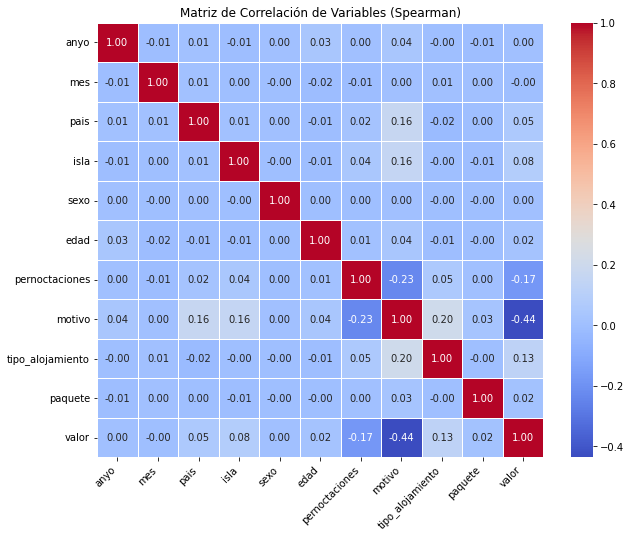

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns

# Load the dataset into a pandas DataFrame (tourist_df)
# Assuming that you already have your dataset loaded into a DataFrame called 'tourist_df'

# Calculate the Spearman correlation matrix
correlation_matrix_spearman = train_df.corr(method='spearman')

# Visualize the correlation matrix using a seaborn heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix_spearman, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, ax=ax)

# Adjust the ticks and labels of the axes
ax.set_xticklabels(correlation_matrix_spearman.columns, rotation=45, ha='right')
ax.set_yticklabels(correlation_matrix_spearman.columns)

# Add a title to the plot
plt.title("Matriz de Correlación de Variables (Spearman)")

# Show the plot
plt.show()


In [30]:
from sklearn.feature_selection import SelectKBest, f_classif

# Seleccionar las variables de entrada (X) y la variable objetivo (y)
input_cols = ['anyo','mes', 'pais', 'sexo', 'edad', 'isla', 'pernoctaciones', 'tipo_alojamiento', 'motivo', 'paquete']
output_cols = ['valor']

X = train_df[input_cols]
y = train_df[output_cols]

# Dividir los datos en conjuntos de entrenamiento y prueba
train_mask = (X['anyo'] >= 2010) & (X['anyo'] <= 2017)
test_mask = (X['anyo'] >= 2018) & (X['anyo'] <= 2019)

X_train = X[train_mask].drop('anyo', axis=1)
y_train = y[train_mask]
X_test = X[test_mask].drop('anyo', axis=1)
y_test = y[test_mask]

selector = SelectKBest(f_classif, k=5)  # Elige las 5 mejores características
X_new = selector.fit_transform(X_train, y_train.values.ravel())

selected_features_f_classif = pd.Series(selector.get_support(), index=X_train.columns)
print(selected_features_f_classif)


mes                 False
pais                 True
sexo                False
edad                False
isla                 True
pernoctaciones       True
tipo_alojamiento     True
motivo               True
paquete             False
dtype: bool


In [31]:
import statsmodels.api as sm

# Seleccionar las variables de entrada (X) y la variable objetivo (y)
input_cols = ['anyo','mes', 'pais', 'sexo', 'edad', 'isla', 'pernoctaciones', 'tipo_alojamiento', 'motivo', 'paquete']
output_cols = ['valor']

X = train_df[input_cols]
y = train_df[output_cols]

# Dividir los datos en conjuntos de entrenamiento y prueba
train_mask = (X['anyo'] >= 2010) & (X['anyo'] <= 2017)
test_mask = (X['anyo'] >= 2018) & (X['anyo'] <= 2019)

X_train = X[train_mask].drop('anyo', axis=1)
y_train = y[train_mask]
X_test = X[test_mask].drop('anyo', axis=1)
y_test = y[test_mask]

# Añade una constante a los datos de entrada
X2 = sm.add_constant(X_train)

# Inicializa una lista para contener las características a eliminar
features_to_remove = []

# Mientras haya características en los datos de entrada
while len(list(X2.columns)) > 1:
    # Entrena un modelo OLS (Ordinary Least Squares)
    model = sm.OLS(y_train, X2).fit()
    
    # Obtiene el valor p para cada característica
    p_values = model.pvalues
    
    # Obtiene la característica con el valor p más alto
    worst_feature = p_values.idxmax()
    
    # Si el valor p más alto es mayor que el umbral (por ejemplo, 0.05)
    if p_values.max() > 0.05:
        # Añade la característica a la lista de características a eliminar
        features_to_remove.append(worst_feature)
        
        # Elimina la característica de los datos de entrada
        X2 = X2.drop(worst_feature, axis=1)
    else:
        # Si ninguna característica tiene un valor p superior al umbral, termina el bucle
        break

# Imprime las características a eliminar
print("Features to remove:")
print(features_to_remove)

# Imprime las características seleccionadas
print("Selected features:")
print(list(X2.columns))


Features to remove:
[]
Selected features:
['const', 'mes', 'pais', 'sexo', 'edad', 'isla', 'pernoctaciones', 'tipo_alojamiento', 'motivo', 'paquete']


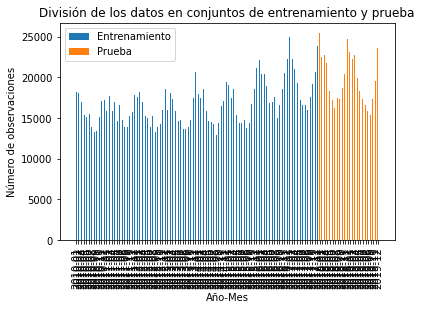

In [52]:
import matplotlib.pyplot as plt

# Crear una nueva columna que combine el año y el mes
train_df['anyo_mes'] = train_df['anyo'].astype(str) + '-' + train_df['mes'].astype(str).str.zfill(2)

# Seleccionar las variables de entrada (X) y la variable objetivo (y)
input_cols = ['anyo_mes','pais', 'sexo', 'edad', 'isla', 'pernoctaciones', 'tipo_alojamiento', 'motivo', 'paquete']
output_cols = ['valor']

X = train_df[input_cols]
y = train_df[output_cols]

# Dividir los datos en conjuntos de entrenamiento y prueba
train_mask = (X['anyo_mes'] >= '2010-01') & (X['anyo_mes'] <= '2017-12')
test_mask = (X['anyo_mes'] >= '2018-01') & (X['anyo_mes'] <= '2019-12')

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

# Crear una serie que contiene el recuento de observaciones para cada año/mes en los conjuntos de entrenamiento y prueba
train_counts = X_train['anyo_mes'].value_counts().sort_index()
test_counts = X_test['anyo_mes'].value_counts().sort_index()

# Crear una figura y un conjunto de ejes
fig, ax = plt.subplots()

# Crear una lista de las etiquetas de los ejes x (año/mes)
x_labels = train_counts.index.union(test_counts.index)

# Dibujar las barras para el conjunto de entrenamiento
ax.bar(x_labels, train_counts.reindex(x_labels, fill_value=0), width=0.4, align='edge', label='Entrenamiento')

# Dibujar las barras para el conjunto de prueba
ax.bar(x_labels, test_counts.reindex(x_labels, fill_value=0), width=-0.4, align='edge', label='Prueba')

# Añadir etiquetas y un título
ax.set_xlabel('Año-Mes')
ax.set_ylabel('Número de observaciones')
ax.set_title('División de los datos en conjuntos de entrenamiento y prueba')
ax.legend()

# Rotar las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=90)

# Mostrar la gráfica
plt.show()


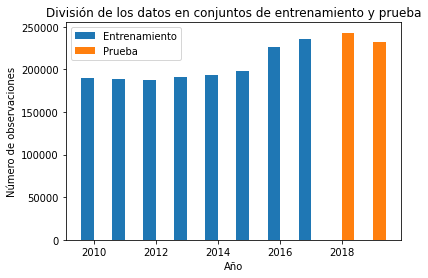

In [53]:
import matplotlib.pyplot as plt

# Seleccionar las variables de entrada (X) y la variable objetivo (y)
input_cols = ['anyo','mes', 'pais', 'sexo', 'edad', 'isla', 'pernoctaciones', 'tipo_alojamiento', 'motivo', 'paquete']
output_cols = ['valor']

X = train_df[input_cols]
y = train_df[output_cols]

# Dividir los datos en conjuntos de entrenamiento y prueba
train_mask = (X['anyo'] >= 2010) & (X['anyo'] <= 2017)
test_mask = (X['anyo'] >= 2018) & (X['anyo'] <= 2019)

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

# Crea una serie que contiene el conteo de observaciones para cada año en los conjuntos de entrenamiento y prueba
train_counts = X_train['anyo'].value_counts().sort_index()
test_counts = X_test['anyo'].value_counts().sort_index()

# Crea una figura y un conjunto de ejes
fig, ax = plt.subplots()

# Dibuja las barras para el conjunto de entrenamiento
ax.bar(train_counts.index - 0.2, train_counts.values, width=0.4, align='center', label='Entrenamiento')

# Dibuja las barras para el conjunto de prueba
ax.bar(test_counts.index + 0.2, test_counts.values, width=0.4, align='center', label='Prueba')

# Agrega etiquetas y un título
ax.set_xlabel('Año')
ax.set_ylabel('Número de observaciones')
ax.set_title('División de los datos en conjuntos de entrenamiento y prueba')
ax.legend()

# Muestra la gráfica
plt.show()

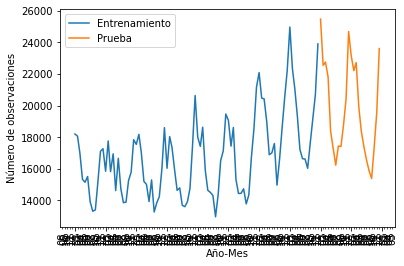

In [56]:
import matplotlib.dates as mdates

# Crear una nueva columna que combine el año y el mes
train_df['anyo_mes'] = train_df['anyo'].astype(str) + '-' + train_df['mes'].astype(str).str.zfill(2)

# Seleccionar las variables de entrada (X) y la variable objetivo (y)
input_cols = ['anyo_mes','pais', 'sexo', 'edad', 'isla', 'pernoctaciones', 'tipo_alojamiento', 'motivo', 'paquete']
output_cols = ['valor']

X = train_df[input_cols]
y = train_df[output_cols]

# Dividir los datos en conjuntos de entrenamiento y prueba
train_mask = (X['anyo_mes'] >= '2010-01') & (X['anyo_mes'] <= '2017-12')
test_mask = (X['anyo_mes'] >= '2018-01') & (X['anyo_mes'] <= '2019-12')

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

# Crear una serie que contiene el recuento de observaciones para cada año/mes en los conjuntos de entrenamiento y prueba
train_counts = X_train['anyo_mes'].value_counts().sort_index()
test_counts = X_test['anyo_mes'].value_counts().sort_index()

# Crear una figura y un conjunto de ejes
fig, ax = plt.subplots()

# Convertir los índices de las series a formato de fecha para el gráfico
x_train = pd.to_datetime(train_counts.index)
x_test = pd.to_datetime(test_counts.index)

# Dibujar las líneas para el conjunto de entrenamiento y prueba
ax.plot(x_train, train_counts.values, label='Entrenamiento')
ax.plot(x_test, test_counts.values, label='Prueba')

# Añadir etiquetas y un título
ax.set_xlabel('Año-Mes')
ax.set_ylabel('Número de observaciones')
#ax.set_title('Evolución de los datos en conjuntos de entrenamiento y prueba')

# Mejorar la legibilidad de las etiquetas de fecha
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)

# Añadir una leyenda
ax.legend()

# Mostrar la gráfica
plt.show()


In [32]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, SelectKBest

# Seleccionar las variables de entrada (X) y la variable objetivo (y)
input_cols = ['anyo','mes', 'pais', 'sexo', 'edad', 'isla', 'pernoctaciones', 'tipo_alojamiento', 'motivo', 'paquete']
output_cols = ['valor']

X = train_df[input_cols]
y = train_df[output_cols]

# Dividir los datos en conjuntos de entrenamiento y prueba
train_mask = (X['anyo'] >= 2010) & (X['anyo'] <= 2017)
test_mask = (X['anyo'] >= 2018) & (X['anyo'] <= 2019)

X_train = X[train_mask].drop('anyo', axis=1)
y_train = y[train_mask]
X_test = X[test_mask].drop('anyo', axis=1)
y_test = y[test_mask]


X_categorical = X_train.apply(LabelEncoder().fit_transform)
selector = SelectKBest(chi2, k=5) # selecciona las 5 mejores características
X_new = selector.fit_transform(X_categorical, y_train)

selected_features_chi2 = pd.Series(selector.get_support(), index=X_train.columns)
print(selected_features_chi2)


mes                  True
pais                 True
sexo                False
edad                False
isla                False
pernoctaciones       True
tipo_alojamiento     True
motivo               True
paquete             False
dtype: bool


In [33]:
cor = train_df.corr()
cor_target = abs(cor["valor"])
relevant_features = cor_target[cor_target>0.5]
print(relevant_features)

valor    1.0
Name: valor, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam


# Seleccionar las variables de entrada (X) y la variable objetivo (y)
input_cols = ['anyo','mes', 'pais', 'sexo', 'edad', 'isla', 'pernoctaciones', 'tipo_alojamiento', 'motivo', 'paquete']
output_cols = ['valor']

X = train_df[input_cols]
y = train_df[output_cols]

# Dividir los datos en conjuntos de entrenamiento y prueba
train_mask = (X['anyo'] >= 2010) & (X['anyo'] <= 2017)
test_mask = (X['anyo'] >= 2018) & (X['anyo'] <= 2019)

X_train = X[train_mask].drop('anyo', axis=1)
y_train = y[train_mask]
X_test = X[test_mask].drop('anyo', axis=1)
y_test = y[test_mask]

# Escalar los datos de entrada
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ajustar la dimensión de los datos de entrada para incluir pasos de tiempo
n_timesteps = 1  # Cada instancia tiene un solo paso de tiempo
n_features = X_train_scaled.shape[1]

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], n_timesteps, n_features))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], n_timesteps, n_features))

# Crear el modelo LSTM
model_lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(n_timesteps, n_features)),
    Dense(1)
])

model_lstm.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mse', 'mae'])

# Entrenar el modelo LSTM
history_lstm = model_lstm.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, verbose=2, validation_data=(X_test_reshaped, y_test))

# Crear el modelo Bidirectional RNN
model_bidirectional = Sequential([
    Bidirectional(LSTM(64, activation='relu'), input_shape=(n_timesteps, n_features)),
    Dense(1)
])

model_bidirectional.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mse', 'mae'])

# Entrenar el modelo Bidirectional RNN
history_bidirectional = model_bidirectional.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, verbose=2, validation_data=(X_test_reshaped, y_test))

# Generar tabla comparativa
results = pd.DataFrame({
    'Metric': ['Loss', 'MSE', 'MAE'],
    'LSTM': [history_lstm.history['loss'][-1], history_lstm.history['mse'][-1], history_lstm.history['mae'][-1]],
    'Bidirectional RNN': [history_bidirectional.history['loss'][-1], history_bidirectional.history['mse'][-1], history_bidirectional.history['mae'][-1]]
})

print(results)

# Crear gráficas comparativas
plt.figure(figsize=(10, 6))

# Training Loss
plt.subplot(2, 2, 1)
plt.plot(history_lstm.history['loss'], label='LSTM')
plt.plot(history_bidirectional.history['loss'], label='Bidirectional RNN')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training MSE
plt.subplot(2, 2, 2)
plt.plot(history_lstm.history['mse'], label='LSTM')
plt.plot(history_bidirectional.history['mse'], label='Bidirectional RNN')
plt.title('Training MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Training MAE
if 'mae' in history_lstm.history and 'mae' in history_bidirectional.history:
    plt.subplot(2, 2, 3)
    plt.plot(history_lstm.history['mae'], label='LSTM')
    plt.plot(history_bidirectional.history['mae'], label='Bidirectional RNN')
    plt.title('Training MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

# Validation Loss
plt.subplot(2, 2, 4)
plt.plot(history_lstm.history['val_loss'], label='LSTM')
plt.plot(history_bidirectional.history['val_loss'], label='Bidirectional RNN')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()
